<a href="https://colab.research.google.com/github/franciscovillaescusa/ML_lectures/blob/main/Lecture1_Parameter_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CAMELS: Cosmology and Astrophysics with Machine Learning Simulations**
[https://www.camel-simulations.org]
- A collection of 4,233 N-body + state-of-the-art (magneto-)hydrodynamic simulations
- Simulations vary 6 cosmological + astrophysical parameters, $\{ \Omega_{\rm m}, \sigma_8, A_{\rm SN1}, A_{\rm SN2}, A_{\rm AGN1}, A_{\rm AGN2}\}$, plus initial random seed
- 2 suites: AREPO/IllustrisTNG + SIMBA/GIZMO
- Each suite contains 4 sets: 
  - **LH**. Each sim has a different values of cosmological, astrophysical and random seed. Organized in a latin-hypercube. 1,000 sims.
  - **1P**: From a central/fiducial cosmology, simulations vary the value of one single parameter at a time. Same random seed for all sims. 61 sims.
  - **CV**: All simulations have the same cosmology and astrophysics, only different random seed. To explore cosmic variance. 27 sims.
  - **EX**: A set of 3 extreme models: 1) No feedback, 2) extreme AGN feedback and 3) extreme supernova feedback. 3 sims.


We are going to use data from the LH set. In particular the Star-formation rate density (SFRH).

SFRH = Global rate of formation of stars per unit of volume. It is a function of redshift:

SFRH = SFRH(z)

When changing cosmology and astrophysics, this quantity will be affected. It is possible to infer the value of the cosmological and astrophysical parameters just from measurements of this quantity:

$\vec{\theta}=f({\rm SFRH}(z))$        
 where 
       
$\vec{\theta}=\{ \Omega_{\rm m}, \sigma_8, A_{\rm SN1}, A_{\rm SN2}, A_{\rm AGN1}, A_{\rm AGN2} \}$ 

We are going to approximate the function $f$ with a neural network.
#############################################################

#### Load libraries

In [1]:
import numpy as np
import sys,os,time
import torch 
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

#### If GPUs are available, use them

In [2]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Available


### Lets get familiar with the data

In [4]:
z      = np.linspace(0.0, 7.0, 100)            #redshifts of the SFRD
SFRD   = np.load('SFRH_IllustrisTNG.npy')      #read SFRD data
params = np.loadtxt('params_IllustrisTNG.txt') #read value of cosmological & astrophysics parameters

#### See the dimensions of the data


In [5]:
print(z.shape)
print(SFRD.shape)
print(params.shape)

(100,)
(1000, 100)
(1000, 6)


#### Lets plot the first two SFRD from the dataset

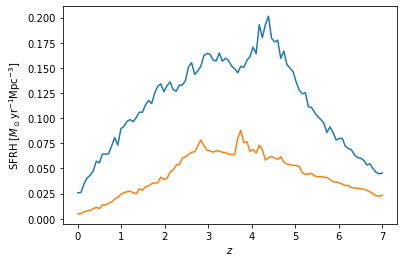

In [6]:
import matplotlib.pyplot as plt
 
plt.ylabel(r'${\rm SFRH}\,\,[M_\odot {\rm yr}^{-1}{\rm Mpc}^{-3}]$')
plt.xlabel(r'$z$')

plt.plot(z, SFRD[0])
plt.plot(z, SFRD[1])
 
plt.show()

#### Get the value of the cosmological and astrophysical parameters for these two SFRD

In [7]:
print('Sim: [Omega_m, sigma_8, A_SN1, A_AGN1, A_SN2, A_AGN2]')
print('0:  ',params[0])
print('1:  ',params[1])

Sim: [Omega_m, sigma_8, A_SN1, A_AGN1, A_SN2, A_AGN2]
0:   [0.309   0.979   3.11234 1.12194 0.6685  0.53182]
1:   [0.3026  0.9394  3.42001 3.96137 1.03311 1.1607 ]


### **Exercise**: calculate range of variation for each parameter, together with their mean value and standard deviation.

### Lets set the value of the parameters

In [8]:
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
f_SFRD         = 'SFRH_IllustrisTNG.npy'   #file with the SFRD data
f_params       = 'params_IllustrisTNG.txt' #file with the value of the parameters
batch_size     = 32                        #number of elements each batch contains
lr             = 1e-4                      #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
dr             = 0.2                       #dropout rate
epochs         = 100                       #number of epochs to train the network
min_valid_loss = 1e7                       #set this to a large number. Used to compute 

### Lets write the function that loads the data.
For convenience, is good to use the pytorch data loader.
We need to define a python class and define the following two protocols:
- `__getitem__()`. Will return the input and output for one particular element of the dataset.
- `__len__()`. Will return the total number of elements in the dataset.italicized text.

It is important to normalize the data. There are two typical options:

- $\tilde{X}=(X-\bar{x})/\sigma_X$
- $\tilde{X}=[X-{\rm min}(X)]/[{\rm max}(X) - {\rm min}(X)]$

In [9]:
# This routine creates a dataset loader
# mode ---------> 'train', 'valid', 'test', 'all'. How to create the dataset
# f_SFRD -------> file containing the data for the SFRD
# f_params -----> file containing the value of the cosmological and astrophysical parameters
# batch_size ---> number of elements in the batch
# seed ---------> the data is randomly shuffled before being split into training, validation and testing. This set the random seed for that. 
def create_dataset(mode, f_SFRD, f_params, batch_size, seed):

    # create the class with the dataset
    data_set = make_dataset(mode, f_SFRD, f_params, seed)

    # create the data loader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)


# This class creates the dataset 
class make_dataset():

    def __init__(self, mode, f_SFRD, f_params, seed):

        # read the data
        SFRD   = np.load('SFRH_IllustrisTNG.npy')      #read SFRD data
        params = np.loadtxt('params_IllustrisTNG.txt') #read value of the parameters

        # normalize the value of the SFRD
        SFRD[np.where(SFRD==0.0)] = 1e-12 #avoid points with SFRD=0
        SFRD = np.log10(SFRD)
        mean = np.mean(SFRD, axis=0, dtype=np.float64)
        std  = np.std(SFRD,  axis=0, dtype=np.float64)
        SFRD = (SFRD - mean)/std

        # Normalize the value of the parameters
        min_params = np.min(params, axis=0)
        max_params = np.max(params, axis=0)
        params     = (params - min_params)/(max_params - min_params)

        # get the number of simulations and number of bins in the SFRD
        simulations = SFRD.shape[0]
        bins        = SFRD.shape[1]

        # get the size and offset depending on the type of dataset
        if   mode=='train':  
            size, offset = int(simulations*0.70), int(simulations*0.00)
        elif mode=='valid':  
            size, offset = int(simulations*0.15), int(simulations*0.70)
        elif mode=='test':   
            size, offset = int(simulations*0.15), int(simulations*0.85)
        elif mode=='all':
            size, offset = int(simulations*1.00), int(simulations*0.00)
        else:    raise Exception('Wrong name!')

        # define size, input and output arrays containing the data
        self.size   = size
        self.input  = torch.zeros((size,bins), dtype=torch.float) #array with the SFRD
        self.output = torch.zeros((size,6),    dtype=torch.float) #array with the parameters

        # randomly shuffle the data. Instead of 0 1 2 3...999 have a 
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        indexes = np.arange(simulations)
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size] #select indexes of the mode

        # get the corresponding parameters and SFRH
        self.input  = torch.tensor(SFRD[indexes],   dtype=torch.float32)
        self.output = torch.tensor(params[indexes], dtype=torch.float32)

    # This protocol returns the size of the dataset
    def __len__(self):
        return self.size

    # This protocol returns 
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

# get the data
train_loader = create_dataset('train', f_SFRD, f_params, batch_size, seed) #training data
valid_loader = create_dataset('valid', f_SFRD, f_params, batch_size, seed) #validation data

### Lets define the architecture of the neural network
Use a python class and define the layers in the `__init__()` protocol and the model in the `forward()` routine.

In [10]:
class one_hidden_layer(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(one_hidden_layer, self).__init__()
        
        # define the fully connected layers
        self.fc1       = nn.Linear(input_size,  hidden_size) 
        self.fc2       = nn.Linear(hidden_size, output_size)

        # define the other layers
        self.dropout   = nn.Dropout(p=dropout_rate)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
       
    # forward pass
    def forward(self, x):
        out = self.fc1(x)
        out = self.LeakyReLU(out)
        out = self.dropout(out)
        out = self.fc2(out)         
        return out

# get the model and move it to the GPU
model = one_hidden_layer(100, 20, 6, dr) #architecture
model.to(device=device)                  #move the architecture to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

total number of parameters in the model = 2146


### Define the loss function and optimizer

In [11]:
criterion = nn.MSELoss()                  #loss function. In this case MSE (mean squared error)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)

## Train!

In [12]:
# do a loop over all epochs
start = time.time()
for epoch in range(epochs):
        
    # do training
    train_loss, points = 0.0, 0
    model.train()  #set this when training. Some architecture pieces, e.g. dropout behave differently
    for SFRH_train, params_train in train_loader:  #do a loop over all elements in the training set

        # move data to GPU
        params_train = params_train.to(device) 
        SFRH_train   = SFRH_train.to(device)  

        # compute the value predicted by the network 
        params_pred  = model(SFRH_train)

        # compute loss 
        loss = criterion(params_pred, params_train)

        # compute cumulative loss and number of examples used
        train_loss += (loss.item())*SFRH_train.shape[0]
        points += SFRH_train.shape[0]

        # zero gradients and do backpropagation. This is the magic!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # get the average training loss
    train_loss /= points


    # do validation
    valid_loss, points = 0.0, 0
    model.eval()   #set this for validation and testing. Some architecture pieces, e.g. dropout behave differently
    for SFRH_val, params_val in valid_loader: # do a loop over all elements in the validation set
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # move data to the GPU
            params_val  = params_val.to(device)
            SFRH_val    = SFRH_val.to(device)

            # compute prediction by the network
            params_pred = model(SFRH_val)

            # compute cumulative loss and number of examples used
            valid_loss += (criterion(params_pred, params_val).item())*SFRH_val.shape[0]
            points += SFRH_val.shape[0]

    # get the average validation loss
    valid_loss /= points

    # save model if it is better
    #if valid_loss<min_valid_loss:
        #print('saving model...')
        #torch.save(model.state_dict(), fmodel)
        #min_valid_loss = valid_loss
    print('%03d %.3e %.3e'%(epoch, train_loss, valid_loss))
    
stop = time.time()
print('Time take (m):', "{:.4f}".format((stop-start)/60.0))

000 3.614e-01 3.167e-01
001 3.181e-01 2.839e-01
002 2.883e-01 2.623e-01
003 2.694e-01 2.450e-01
004 2.544e-01 2.293e-01
005 2.412e-01 2.146e-01
006 2.281e-01 2.000e-01
007 2.171e-01 1.863e-01
008 2.038e-01 1.741e-01
009 2.027e-01 1.638e-01
010 1.839e-01 1.542e-01
011 1.819e-01 1.463e-01
012 1.756e-01 1.399e-01
013 1.748e-01 1.346e-01
014 1.667e-01 1.300e-01
015 1.641e-01 1.266e-01
016 1.608e-01 1.233e-01
017 1.588e-01 1.205e-01
018 1.537e-01 1.181e-01
019 1.478e-01 1.159e-01
020 1.518e-01 1.137e-01
021 1.454e-01 1.121e-01
022 1.439e-01 1.106e-01
023 1.405e-01 1.090e-01
024 1.372e-01 1.076e-01
025 1.318e-01 1.059e-01
026 1.312e-01 1.042e-01
027 1.328e-01 1.028e-01
028 1.296e-01 1.016e-01
029 1.311e-01 1.002e-01
030 1.305e-01 9.876e-02
031 1.274e-01 9.728e-02
032 1.229e-01 9.581e-02
033 1.231e-01 9.393e-02
034 1.204e-01 9.269e-02
035 1.198e-01 9.162e-02
036 1.146e-01 9.014e-02
037 1.149e-01 8.866e-02
038 1.137e-01 8.747e-02
039 1.115e-01 8.612e-02
040 1.105e-01 8.484e-02
041 1.073e-01 8.